In [24]:
r_ds = torch.load("/playpen/tgreer/knees_test_set_hires")

In [35]:
import random

import footsteps
import icon_registration as icon
import itk
import torch
import matplotlib.pyplot as plt
from icon_registration.pretrained_models import OAI_knees_gradICON_model
import numpy as np
from icon_registration.mermaidlite import compute_warped_image_multiNC
from icon_registration.losses import flips

In [9]:
atlas = torch.load("results/mean_initialized-1/atlas.torch").detach()
atlas2 = itk.array_from_image(itk.imread("../ICON_atlas/atlas_60_LEFT_baseline_NMI/atlas_image.nii.gz"))
atlas2 = torch.tensor(atlas2)[None, None, ::2, ::2, ::2]

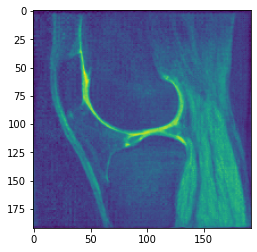

In [13]:
plt.imshow(atlas[0, 0, 30])

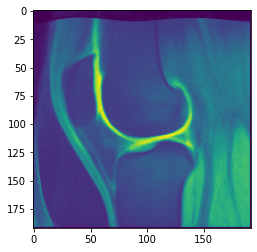

In [14]:
plt.imshow(atlas2[0, 0, 30])

In [27]:
class ViaAtlasRegistration(icon.RegistrationModule):
    def __init__(self, net: icon.RegistrationModule, atlas:torch.Tensor):
        super().__init__()
        self.register_buffer("atlas", atlas)
        self.net = net
    def forward(self, image_A, image_B):
        phi = self.net(image_A, self.atlas.expand(image_A.shape[0], -1, -1, -1, -1))
        psi = self.net(self.atlas.expand(image_A.shape[0], -1, -1, -1, -1), image_B)

        ret = lambda input_: phi(psi(input_))
        return ret

In [21]:
gradICON = OAI_knees_gradICON_model(pretrained=True)

In [29]:
atlas_registration = icon.GradientICON(
    ViaAtlasRegistration(
        gradICON.regis_net,
        atlas
    ),
    icon.ssd_only_interpolated,
    2
)
atlas_registration.assign_identity_map(atlas.shape)

tensor([0.7058, 0.7678], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7456, 0.6704], device='cuda:0')
tensor(0., device='cuda:0')
tensor(19., device='cuda:0')
tensor([0.6941, 0.6674], device='cuda:0')
tensor(3., device='cuda:0')
tensor(6., device='cuda:0')
tensor([0.7780, 0.6976], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7154, 0.7608], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7149, 0.7778], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7430, 0.6322], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.6603, 0.7680], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.6837, 0.7191], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.6842, 0.7225], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7025, 0.7

tensor([0.7017, 0.7123], device='cuda:0')
tensor(2., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7402, 0.7372], device='cuda:0')
tensor(0., device='cuda:0')
tensor(5., device='cuda:0')
tensor([0.7289, 0.7399], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.6604, 0.7497], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7237, 0.7270], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.7128)
1.6853932584269662
RESULTS NEW ATLAS =================
0.712777
1.6853932584269662


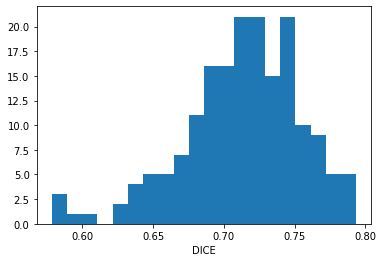

In [36]:
batched_ds = list(zip(*[r_ds[i::2] for i in range(2)]))
atlas_registration.cuda()
with torch.no_grad():
    dices = []
    folds_list = []
    
    filteredDV_list = []
    
    
    for x in batched_ds[:89]:
        x = list(zip(*x))
        x = [torch.cat(r, 0).cuda().float() for r in x]
        fixed_image, fixed_cartilage = x[0], x[2]
        moving_image, moving_cartilage = x[1], x[3]
        atlas_registration(moving_image, fixed_image)
        
        phi_AB_vectorfield = atlas_registration.phi_AB_vectorfield
        fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(phi_AB_vectorfield[:, :3])
        sz = np.array(fat_phi.size())
        spacing = 1./(sz[2::]-1) 
        warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)
        wmb = warped_moving_cartilage > .5
        fb = fixed_cartilage > .5
        intersection = wmb * fb
        d = 2 * torch.sum(intersection, [1,2,3,4]).float() / (torch.sum(wmb, [1,2,3,4]) + torch.sum(fb, [1,2,3,4]))
        print(d)
        dices.append(d)
        f = flips(phi_AB_vectorfield[:1])
        print(f)
        folds_list.append(f.item())
        f = flips(phi_AB_vectorfield[1:])
        print(f)
        folds_list.append(f.item())
        
        #filteredDV_list.append(dV)
        
    dd = torch.mean(torch.cat(dices).cpu())
    print(dd)
    ff = np.mean(folds_list)
    print(ff)
print("RESULTS NEW ATLAS =================")
dicesa = np.array(torch.cat(dices).cpu())
plt.hist(dicesa, 20)
plt.xlabel("DICE")
print(np.mean(dicesa))
ff = np.mean(folds_list)
print(ff)

In [37]:
atlas_registration_old = icon.GradientICON(
    ViaAtlasRegistration(
        gradICON.regis_net,
        atlas2
    ),
    icon.ssd_only_interpolated,
    2
)
atlas_registration_old.assign_identity_map(atlas.shape)

tensor([0.7013, 0.7582], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7427, 0.6587], device='cuda:0')
tensor(0., device='cuda:0')
tensor(20., device='cuda:0')
tensor([0.7013, 0.6618], device='cuda:0')
tensor(0., device='cuda:0')
tensor(23., device='cuda:0')
tensor([0.7637, 0.6811], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7046, 0.7554], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.6996, 0.7677], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7483, 0.6197], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.6593, 0.7516], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.6730, 0.7027], device='cuda:0')
tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.6428, 0.7109], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7054, 0.

tensor([0.6927, 0.7145], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7281, 0.7294], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7254, 0.7426], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.6717, 0.7456], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.7122, 0.7233], device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.7062)
1.1853932584269662
RESULTS OLD ATLAS =================
0.7061564
1.1853932584269662


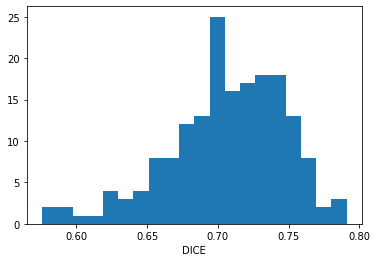

In [38]:
atlas_registration_old.cuda()
with torch.no_grad():
    dices = []
    folds_list = []
    
    filteredDV_list = []
    
    
    for x in batched_ds[:89]:
        x = list(zip(*x))
        x = [torch.cat(r, 0).cuda().float() for r in x]
        fixed_image, fixed_cartilage = x[0], x[2]
        moving_image, moving_cartilage = x[1], x[3]
        atlas_registration_old(moving_image, fixed_image)
        
        phi_AB_vectorfield = atlas_registration_old.phi_AB_vectorfield
        fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(phi_AB_vectorfield[:, :3])
        sz = np.array(fat_phi.size())
        spacing = 1./(sz[2::]-1) 
        warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)
        wmb = warped_moving_cartilage > .5
        fb = fixed_cartilage > .5
        intersection = wmb * fb
        d = 2 * torch.sum(intersection, [1,2,3,4]).float() / (torch.sum(wmb, [1,2,3,4]) + torch.sum(fb, [1,2,3,4]))
        print(d)
        dices.append(d)
        f = flips(phi_AB_vectorfield[:1])
        print(f)
        folds_list.append(f.item())
        f = flips(phi_AB_vectorfield[1:])
        print(f)
        folds_list.append(f.item())
        
        #filteredDV_list.append(dV)
        
    dd = torch.mean(torch.cat(dices).cpu())
    print(dd)
    ff = np.mean(folds_list)
    print(ff)
print("RESULTS OLD ATLAS =================")
dicesa = np.array(torch.cat(dices).cpu())
plt.hist(dicesa, 20)
plt.xlabel("DICE")
print(np.mean(dicesa))
ff = np.mean(folds_list)
print(ff)